# Crop type mapping with deep learning
> A guide for using deep-learning based semantic segmentation to map crop types in satellite imagery.

- toc: true
- badges: true
- author: Lilly Thomas ([adapted from TensorFlow Developers](https://www.tensorflow.org/tutorials/images/segmentation))
- comments: false
- hide: true
- categories: [python, deep learning, machine learning, segmentation, classification, tensorflow]

In this tutorial we will learn how to segment images. **Segmentation** is the process of generating pixel-wise segmentations giving the class of the object visible at each pixel. For example, we could be identifying the location and boundaries of people within an image or identifying cell nuclei from an image. Formally, image segmentation refers to the process of partitioning an image into a set of pixels that we desire to identify (our target) and the background. 

Specifically, in this tutorial we will be using the [Farm Pin Crop Detection Challenge](https://zindi.africa/competitions/farm-pin-crop-detection-challenge). 

This challenge provides ground truth crop type labels with multiple Sentinel 2 scenes captured at different timesteps between January and August of 2017. The area of interest lies along a section of the Orange River in South Africa. Our task will be to predict the crop types in an image on a pixel-wise basis. 

## Specific concepts that will be covered:
In the process, we will build practical experience and develop intuition around the following concepts:
* **[Functional API](https://keras.io/getting-started/functional-api-guide/)** - we will be implementing UNet, a convolutional network model classically used for biomedical image segmentation with the Functional API. 
  * This model has layers that require multiple input/outputs. This requires the use of the functional API
  * Check out the original [paper](https://arxiv.org/abs/1505.04597), 
U-Net: Convolutional Networks for Biomedical Image Segmentation by Olaf Ronneberger!
* **Loss Functions and Metrics** - We'll implement the **Sparse Categorical focal loss function**
(https://focal-loss.readthedocs.io/en/latest/) and **accuracy**. We'll also implement **mean intersection over union** during evaluation and and generate confusion matrices during evaluation to judge how well the model performs. 
* **Saving and loading keras models** - We'll save our best model to file. When we want to perform inference/evaluate our model in the future, we can load the model file. 

### We will follow the general workflow:
1. Load ZINDI datasets from Google Drive
2. Compute spectral indices useful for crop type mapping
3. Visualize data/perform some exploratory data analysis
4. Set up data pipeline and preprocessing
5. Build model
6. Train model
7. Test model
8. Evaluate model 

**Audience:** This post is geared towards intermediate users who are comfortable with basic machine learning concepts. 

**Time Estimated**: 120 min

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [14]:
root_dir = 'gdrive/My Drive/croptype/'

In [ ]:
%cd $root_dir

In [ ]:
!pip install rasterio
!pip install geopandas
!pip install git+https://github.com/tensorflow/examples.git
!pip install -U tfds-nightly
!pip install focal-loss

In [17]:
import os
import glob
import functools
from zipfile import ZipFile
import fnmatch
from itertools import product

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)

from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import pandas as pd
from PIL import Image

import rasterio
from rasterio import features
from rasterio import mask 
from rasterio import windows

import geopandas as gpd

import tensorflow as tf
from tensorflow.python.keras import layers
from tensorflow.python.keras import losses
from tensorflow.python.keras import models
from tensorflow.python.keras import backend as K  
import tensorflow_addons as tfa

from tensorflow_examples.models.pix2pix import pix2pix

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt

from focal_loss import SparseCategoricalFocalLoss
from sklearn.metrics import confusion_matrix

# Get all the data 

### We'll download the data from ZINDI

The data is available on our shared google drive. Or you can register an account on https://zindi.africa/ and download other or more Sentinel 2 timestamps from the competition.

The training labels:

`train.zip`

Four Sentinel 2 collects from 2017 to start (March 22, May 31, June 20 and August 4). See the document "OrangeRiver_Climate.docx" provided in the ZINDI competition data for information on the local climate and growing season.

`2017-03-22.zip` \
`2017-08-04.zip` \
`2017-05-31.zip` \
`2017-06-20.zip`


In [18]:
root_dir = './'
sentinel_timestamps = ['2017-03-22', '2017-05-31', '2017-06-20', '2017-08-04']
sentinel_timestamp = sentinel_timestamps[1]
target_crs = 'epsg:32734'

In [10]:
# Unzip all of the ZINDI competition data
for z in glob.glob('./*.zip'):
    filename_split = os.path.splitext(z)
    filename_zero, fileext = filename_split
    basename = os.path.basename(filename_zero)
    with ZipFile(z, 'r') as zf:
        zf.extractall(basename)

### Timestamp processing start

Get the band images. We only need Sentinel-2's Band 2, 3, 4, and 8 (blue, green, red, NIR) to compute the spectral indices of use.

In [19]:
def sentinel_read(sentinel_timestamp):
    sentinel_dir = os.path.join(root_dir,sentinel_timestamp)
    bands = glob.glob(sentinel_dir+'/**/*.jp2',recursive=True)

    # Read band metadata and arrays
    # metadata
    src_2 = rasterio.open(fnmatch.filter(bands, '*B02.jp2')[0])
    src_3 = rasterio.open(fnmatch.filter(bands, '*B03.jp2')[0])
    src_4 = rasterio.open(fnmatch.filter(bands, '*B04.jp2')[0])
    src_8 = rasterio.open(fnmatch.filter(bands, '*B08.jp2')[0])

    # array
    arr_2 = src_2.read()
    arr_3 = src_3.read()
    arr_4 = src_4.read()
    arr_8 = src_8.read()
    return sentinel_dir, arr_2, arr_3, arr_4, arr_8, src_8

#### Now let's calculate the spectral indices

**NDVI**: Normalized Difference Vegetation Index \
**SAVI**: Soil Adjusted Vegetation Index \
**WDRVI**: Wide Dynamic Range Vegetation Index 

In [20]:
def indexnormstack(blue, green, red, nir):
    
    def NDIcalc(nir, red): 
        ndi = (nir - red) / (nir  + red + 1e-5) 
        return ndi
    
    def GARIcalc(blue, green, red, nir):
        gamma = 1.7
        gari = (nir  - (green - (gamma * (blue - red)))) / (nir  + (green - (gamma * (blue - red))))
        return gari
    
    def OSAVIcalc(red, nir):
        osavi = (nir - red) / (nir + red + 0.16)
        return osavi
    
    def WRDVIcalc(red,nir):
        a = 0.2
        wdrvi = (a * nir - red) / (a * nir - red)
        return wdrvi
    
    def SAVIcalc(red, nir):
        savi = 1.5 * (nir - red) / (nir + red + 0.5)
        return savi
    
    def EVIcalc(blue,red,nir):
        evi = (nir - red) / (nir + 6 * red - 7.5 * blue - 1)
        return evi
    
    def norm(arr):
        arr_norm = (255*(arr - np.min(arr))/np.ptp(arr)) 
        return arr_norm
    
    ndvi = NDIcalc(nir,red) 
    #ndvi_norm = norm(ndvi)
    
    savi = SAVIcalc(red,nir) 
    #savi_norm = norm(savi)
    
    wdrvi = WRDVIcalc(red,nir)
    #wdrvi_norm = norm(wdrvi)
    

    ndvi = ndvi.transpose(1,2,0)
    savi = savi.transpose(1,2,0)
    wdrvi = wdrvi.transpose(1,2,0)

    index_stack = np.dstack((ndvi, savi, wdrvi))
    
    return index_stack

Read label shapefile into geopandas dataframe, check for invalid geometries and set to local CRS. Then, rasterize the labeled polygons using the metadata from one of the grayscale band images.

In [21]:
def label(geo, src_8):
    geo = gpd.read_file(geo)
    geo = geo.loc[geo.is_valid] 
    geo = geo.to_crs(crs={'init': target_crs})
    geo['Crop_Id_Ne_int']  = geo.Crop_Id_Ne.astype(int)
    shapes = ((geom,value) for geom, value in zip(geo.geometry, geo.Crop_Id_Ne_int)) 
    src_8_prf = src_8.profile
    labels = features.rasterize(shapes=shapes, out_shape=(src_8_prf['height'], src_8_prf['width']), fill=0, all_touched=True, transform=src_8_prf['transform'], dtype=src_8_prf['dtype'])
    print("Check values in labeled image: ", np.unique(labels))
    return labels

In [27]:
def save_images(sentinel_dir, index_stack, labels, src_8):
    index_stack = (index_stack * 255).astype(np.uint8)
    index_stack_t = index_stack.transpose(2,0,1)
    labels = labels.astype(np.uint8)

    index_stack_out=rasterio.open(sentinel_dir+'/index_stack.tiff', 'w', driver='Gtiff',
                              width=src_8.width, height=src_8.height,
                              count=3,
                              crs=src_8.crs,
                              transform=src_8.transform,
                              dtype='uint8')

    index_stack_out.write(index_stack_t)
    index_stack_out.close()

    labels_out=rasterio.open(sentinel_dir+'/labels.tiff', 'w', driver='Gtiff',
                              width=src_8.width, height=src_8.height,
                              count=1,
                              crs=src_8.crs,
                              transform=src_8.transform,
                              dtype='uint8')

    labels_out.write(labels, 1)
    labels_out.close()

Now let's divide the Sentinel 2 index stack and labeled image into 224x224 pixel tiles

In [23]:
def tile(index_stack, labels):
    tiles_dir = root_dir+'tiled/'
    img_dir = root_dir+'tiled/images/'
    label_dir = root_dir+'tiled/labels/'
    dirs = [tiles_dir, img_dir, label_dir]
    for d in dirs:
        if not os.path.exists(d):
            os.makedirs(d)
    
    height,width = 224, 224
    
    def get_tiles(ds, width=224, height=224):
        nols, nrows = ds.meta['width'], ds.meta['height']
        offsets = product(range(0, nols, width), range(0, nrows, height))
        big_window = windows.Window(col_off=0, row_off=0, width=nols, height=nrows)
        for col_off, row_off in  offsets:
            window =windows.Window(col_off=col_off, row_off=row_off, width=width, height=height).intersection(big_window)
            transform = windows.transform(window, ds.transform)
            yield window, transform
      
    tile_width, tile_height = 224, 224
    
    def crop(inpath, outpath, c):
        image = rasterio.open(inpath)
        meta = image.meta.copy()
        meta['count'] = int(c)
        meta['driver']='PNG'
        i = 0
        for window, transform in get_tiles(image):
            meta['transform'] = transform
            meta['width'], meta['height'] = window.width, window.height
            outfile = outpath+"tile_%s_%s.png" % (sentinel_timestamp, str(i))
            with rasterio.open(outfile, 'w', **meta) as outds:
                outds.write(image.read(window=window))
            i = i+1
            
    def process_tiles(index_flag):
        if index_flag==True:
            inpath = sentinel_dir+'/index_stack.tiff'
            outpath=img_dir
            crop(inpath, outpath, 3)
        else:
            inpath = sentinel_dir+'/labels.tiff'
            outpath=label_dir
            crop(inpath, outpath, 1)
                
    process_tiles(index_flag=True) # tile index stack
    process_tiles(index_flag=False) # tile labels
    return tiles_dir, img_dir, label_dir

Run the image processing workflow

In [ ]:
def main(timestamp):
    sentinel_dir, arr_2, arr_3, arr_4, arr_8, src_8 = sentinel_read(timestamp)

    # Calculate indices and combine the indices into one single 3 channel image
    index_stack = indexnormstack(arr_2, arr_3, arr_4, arr_8)

    # Rasterize labels
    labels = label(root_dir+'train/train/train.shp', src_8)

    # Save index stack and labels to geotiff
    index_stack_file, labels_file = save_images(sentinel_dir, index_stack, labels, src_8)

    # Tile images into 224x224
    tiles_dir, img_dir, label_dir = tile(index_stack, labels)

    return timestamp, tiles_dir, img_dir, label_dir

for timestamp in sentinel_timestamps:
    timestamp, tiles_dir, img_dir, label_dir = main(timestamp)

----------------------------------------------------------------------------------------------

### Read into tensorflow datasets

Now we will compile the spectral index image and label tiles into training, validation, and test datasets for use with TensorFlow.

In [ ]:
train_imgs = glob.glob(img_dir+"/*.png")
train_list = []
for img in train_imgs:
    filename_split = os.path.splitext(img) 
    filename_zero, fileext = filename_split 
    basename = os.path.basename(filename_zero) 
    train_list.append(basename)
    
x_train_filenames = []
y_train_filenames = []
for img_id in train_list:
  x_train_filenames.append(os.path.join(img_dir, "{}.png".format(img_id)))
  y_train_filenames.append(os.path.join(label_dir, "{}.png".format(img_id)))
    
    
print(len(train_list))

Let's check for the proportion of background tiles.

In [28]:
background_list = []
for i in train_list: 
    img = np.array(Image.open(os.path.join(label_dir, "{}.png".format(i)))) 
    if img.max()==0:
        background_list.append(i)
        
print(len(background_list))

9620


We will keep only 10% of the total. Too many background tiles can cause a form of class imbalance.

In [29]:
background_removal = len(background_list) * 0.9
train_list_clean = [y for y in train_list if y not in background_list[0:int(background_removal)]]

x_train_filenames = []
y_train_filenames = []
for img_id in train_list_clean: 
  x_train_filenames.append(os.path.join(img_dir, "{}.png".format(img_id)))
  y_train_filenames.append(os.path.join(label_dir, "{}.png".format(img_id)))
    
print(len(train_list_clean))

1342


Split index tiles and label tiles into train and test sets: 90% and 10%, respectively.

In [30]:
x_train_filenames, x_val_filenames, y_train_filenames, y_val_filenames = train_test_split(x_train_filenames, y_train_filenames, test_size=0.1, random_state=42)

num_train_examples = len(x_train_filenames)
num_val_examples = len(x_val_filenames)

print("Number of training examples: {}".format(num_train_examples))
print("Number of validation examples: {}".format(num_val_examples))

Number of training examples: 1207
Number of validation examples: 135


### Visualize the data

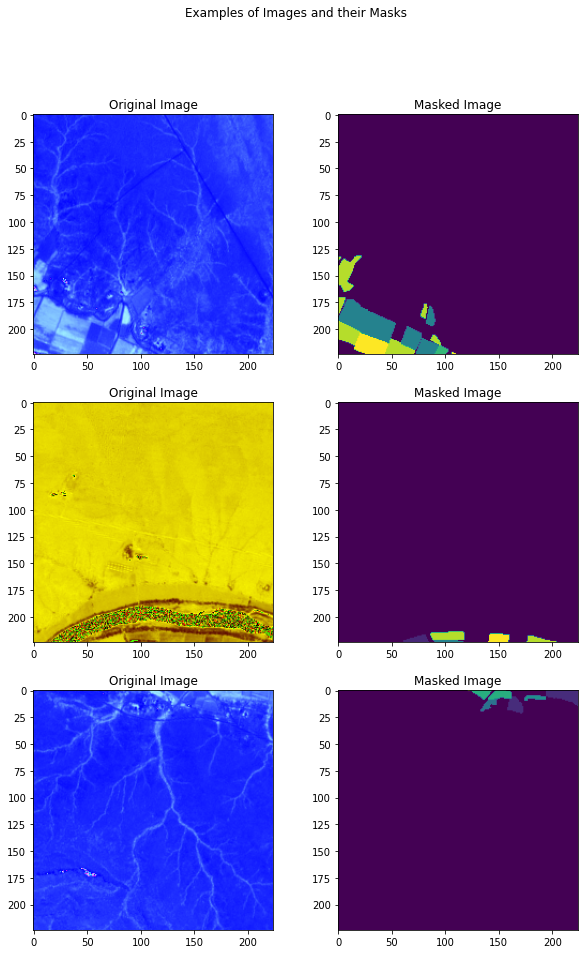

In [31]:
display_num = 3

foreground_list_x = []
foreground_list_y = []
for x,y in zip(x_train_filenames, y_train_filenames): 
    img = np.array(Image.open(y)) 
    if img.max()>0:
        foreground_list_x.append(x)
        foreground_list_y.append(y)

num_foreground_examples = len(foreground_list_y)
        
r_choices = np.random.choice(num_foreground_examples, display_num)

plt.figure(figsize=(10, 15))
for i in range(0, display_num * 2, 2):
  img_num = r_choices[i // 2]
  x_pathname = foreground_list_x[img_num]
  y_pathname = foreground_list_y[img_num]
  
  plt.subplot(display_num, 2, i + 1)
  plt.imshow(mpimg.imread(x_pathname))
  plt.title("Original Image")
  
  example_labels = Image.open(y_pathname)
  label_vals = np.unique(np.array(example_labels))
  
  plt.subplot(display_num, 2, i + 2)
  plt.imshow(example_labels)
  plt.title("Masked Image")  
  
plt.suptitle("Examples of Images and their Masks")
plt.show()

### Read the tiles into tensors

In [34]:
img_shape = (224, 224, 3)
batch_size = 2

In [35]:
def _process_pathnames(fname, label_path):
  # We map this function onto each pathname pair  
  img_str = tf.io.read_file(fname)
  img = tf.image.decode_png(img_str, channels=3)

  label_img_str = tf.io.read_file(label_path)

  # These are png images so they return as (num_frames, h, w, c)
  label_img = tf.image.decode_png(label_img_str, channels=1)
  # The label image should have any values between 0 and 9, indicating pixel wise
  # cropt type class or background (0). We take the first channel only. 
  label_img = label_img[:, :, 0]
  label_img = tf.expand_dims(label_img, axis=-1)
  return img, label_img

In [36]:
def flip_img_h(horizontal_flip, tr_img, label_img):
  if horizontal_flip:
    flip_prob = tf.random.uniform([], 0.0, 1.0)
    tr_img, label_img = tf.cond(tf.less(flip_prob, 0.5),
                                lambda: (tf.image.flip_left_right(tr_img), tf.image.flip_left_right(label_img)),
                                lambda: (tr_img, label_img))
  return tr_img, label_img

In [37]:
def flip_img_v(vertical_flip, tr_img, label_img):
  if vertical_flip:
    flip_prob = tf.random.uniform([], 0.0, 1.0)
    tr_img, label_img = tf.cond(tf.less(flip_prob, 0.5),
                                lambda: (tf.image.flip_up_down(tr_img), tf.image.flip_up_down(label_img)),
                                lambda: (tr_img, label_img))
  return tr_img, label_img

In [38]:
def _augment(img,
             label_img,
             resize=None,  # Resize the image to some size e.g. [256, 256]
             scale=1,  # Scale image e.g. 1 / 255.
             horizontal_flip=False,
             vertical_flip=False): 
  if resize is not None:
    # Resize both images
    label_img = tf.image.resize(label_img, resize)
    img = tf.image.resize(img, resize)
  
  img, label_img = flip_img_h(horizontal_flip, img, label_img)
  img, label_img = flip_img_v(vertical_flip, img, label_img)
  img = tf.cast(img, tf.float32) * scale  #tf.to_float(img) * scale 
  #print("tensor: ", tf.unique(tf.keras.backend.print_tensor(label_img)))
  return img, label_img

In [39]:
def get_baseline_dataset(filenames, 
                         labels,
                         preproc_fn=functools.partial(_augment),
                         threads=5, 
                         batch_size=batch_size,
                         shuffle=True):           
  num_x = len(filenames)
  # Create a dataset from the filenames and labels
  dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
  # Map our preprocessing function to every element in our dataset, taking
  # advantage of multithreading
  dataset = dataset.map(_process_pathnames, num_parallel_calls=threads)
  if preproc_fn.keywords is not None and 'resize' not in preproc_fn.keywords:
    assert batch_size == 1, "Batching images must be of the same size"

  dataset = dataset.map(preproc_fn, num_parallel_calls=threads)
  
  if shuffle:
    dataset = dataset.shuffle(num_x)
  
  
  # It's necessary to repeat our data for all epochs 
  dataset = dataset.repeat().batch(batch_size)
  return dataset

In [40]:
tr_cfg = {
    'resize': [img_shape[0], img_shape[1]],
    'scale': 1 / 255.,
    'horizontal_flip': True,
    'vertical_flip': True,
}
tr_preprocessing_fn = functools.partial(_augment, **tr_cfg)

In [41]:
val_cfg = {
    'resize': [img_shape[0], img_shape[1]],
    'scale': 1 / 255.,
}
val_preprocessing_fn = functools.partial(_augment, **val_cfg)

In [42]:
train_ds = get_baseline_dataset(x_train_filenames,
                                y_train_filenames,
                                preproc_fn=tr_preprocessing_fn,
                                batch_size=batch_size)
val_ds = get_baseline_dataset(x_val_filenames,
                              y_val_filenames, 
                              preproc_fn=val_preprocessing_fn,
                              batch_size=batch_size)

In [43]:
display_num = 1
r_choices = np.random.choice(num_foreground_examples, 1)
for i in range(0, display_num * 2, 2):
  img_num = r_choices[i // 2]

temp_ds = get_baseline_dataset(foreground_list_x[img_num:img_num+1], 
                               foreground_list_y[img_num:img_num+1],
                               preproc_fn=tr_preprocessing_fn,
                               batch_size=1,
                               shuffle=False)

# Let's examine some of these augmented images

iterator = iter(temp_ds)
next_element = iterator.get_next()

batch_of_imgs, label = next_element

# Running next element in our graph will produce a batch of images

sample_image, sample_mask = batch_of_imgs[0], label[0,:,:,:]

In [44]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

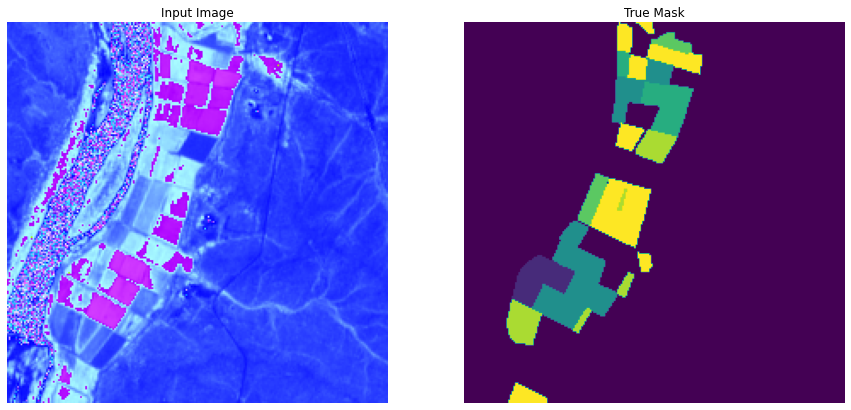

In [45]:
display([sample_image, sample_mask])

...same check for the validation images:

In [46]:
foreground_list_x = []
foreground_list_y = []
for x,y in zip(x_val_filenames, y_val_filenames): 
    img = np.array(Image.open(y)) 
    if img.max()>0:
        foreground_list_x.append(x)
        foreground_list_y.append(y)

num_foreground_examples = len(foreground_list_y)

In [47]:
display_num = 1
r_choices = np.random.choice(num_foreground_examples, 1)
for i in range(0, display_num * 2, 2):
  img_num = r_choices[i // 2]

temp_ds = get_baseline_dataset(foreground_list_x[img_num:img_num+1], 
                               foreground_list_y[img_num:img_num+1],
                               preproc_fn=tr_preprocessing_fn,
                               batch_size=1,
                               shuffle=False)

# Let's examine some of these augmented images

iterator = iter(temp_ds)
next_element = iterator.get_next()

batch_of_imgs, label = next_element

# Running next element in our graph will produce a batch of images

sample_image, sample_mask = batch_of_imgs[0], label[0,:,:,:]

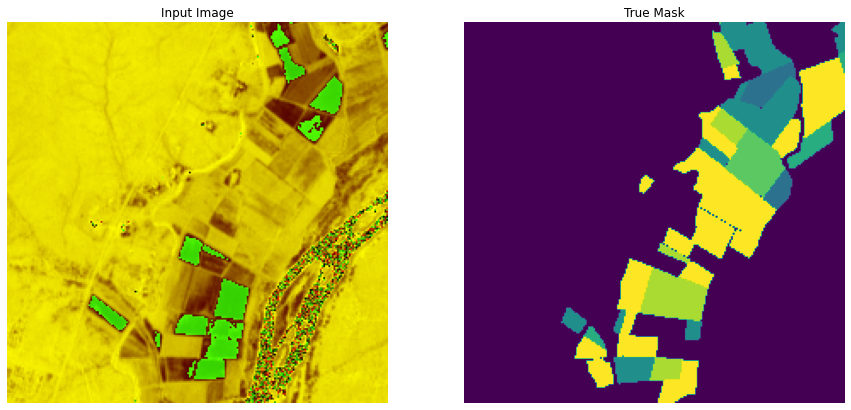

In [48]:
display([sample_image, sample_mask])

### Define the model

The model being used here is a modified U-Net. A U-Net consists of an encoder (downsampler) and decoder (upsampler). In-order to learn robust features, and reduce the number of trainable parameters, a pretrained model can be used as the encoder. Thus, the encoder for this task will be a pretrained MobileNetV2 model, whose intermediate outputs will be used, and the decoder will be the upsample block already implemented in TensorFlow Examples in the Pix2pix tutorial.

The reason to output ten channels is because there are ten possible labels for each pixel. Think of this as multi-classification where each pixel is being classified into ten classes.

In [49]:
OUTPUT_CHANNELS = 10

As mentioned, the encoder will be a pretrained MobileNetV2 model which is prepared and ready to use in tf.keras.applications. The encoder consists of specific outputs from intermediate layers in the model. Note that the encoder will not be trained during the training process.

In [50]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[224, 224, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


The decoder/upsampler is simply a series of upsample blocks implemented in TensorFlow examples.

In [51]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [52]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[224,224,3])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 224x224

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

### Train the model

Now, all that is left to do is to compile and train the model. The loss being used here is losses.SparseCategoricalCrossentropy(from_logits=True). The reason to use this loss function is because the network is trying to assign each pixel a label, just like multi-class prediction. In the true segmentation mask, each pixel has a value between 0-9. The network here is outputting ten channels. Essentially, each channel is trying to learn to predict a class, and losses.SparseCategoricalCrossentropy(from_logits=True) is the recommended loss for such a scenario. Using the output of the network, the label assigned to the pixel is the channel with the highest value. This is what the create_mask function is doing.

In [53]:
model = unet_model(OUTPUT_CHANNELS)

Notice there is a class imbalance problem in the dataset. For that reason, we will use a loss function called focal loss. It uses a parameter to weigh the losses contributed by each class to prevent bias towards the over-represented.

In [54]:
train_df = pd.read_csv('Farmpin_training.csv')
inv_freq = np.array(1/(train_df.crop_id.value_counts()/len(train_df)))
inv_freq = [0.,*inv_freq]
class_weights = {0 : inv_freq[0], 1: inv_freq[1], 2: inv_freq[2], 3: inv_freq[3], 
                4: inv_freq[4], 5: inv_freq[5], 6: inv_freq[6],
                7: inv_freq[7], 8: inv_freq[8], 9: inv_freq[9]}

In [55]:
class_weights

{0: 0.0,
 1: 2.647932131495228,
 2: 4.6585820895522385,
 3: 8.823321554770319,
 4: 9.352059925093632,
 5: 16.98639455782313,
 6: 17.58450704225352,
 7: 26.28421052631579,
 8: 32.42857142857143,
 9: 356.7142857142857}

We will measure our model's performance during training by per-pixel accuracy.

In [56]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001),
              loss=SparseCategoricalFocalLoss(gamma=2, from_logits=True),
              metrics=['accuracy'])


Have a quick look at the resulting model architecture:

In [57]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
functional_1 (Functional)       [(None, 112, 112, 96 1841984     input_2[0][0]                    
__________________________________________________________________________________________________
sequential (Sequential)         (None, 14, 14, 512)  1476608     functional_1[0][4]               
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 14, 14, 1088) 0           sequential[0][0]                 
                                                                 functional_1[0][3]    

Let's try out the pre-trained model to see what it predicts before training.

In [58]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [59]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    mp = create_mask(model.predict(sample_image[tf.newaxis, ...]))
    mpe = tf.keras.backend.eval(mp)
    display([sample_image, sample_mask, mpe])

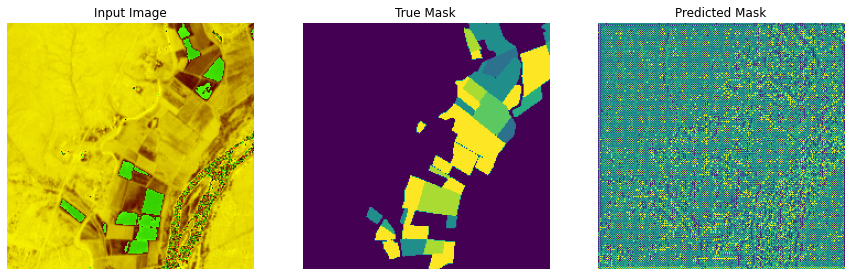

In [60]:
show_predictions()

Let's observe how the model improves while it is training. To accomplish this task, a callback function is defined below to plot a validation image and it's predicted mask after each epoch.

In [61]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

#### Now we will actually train the model for 20 epochs (full sycles through the training dataset), visualizing predictions on a validation image after each epoch.

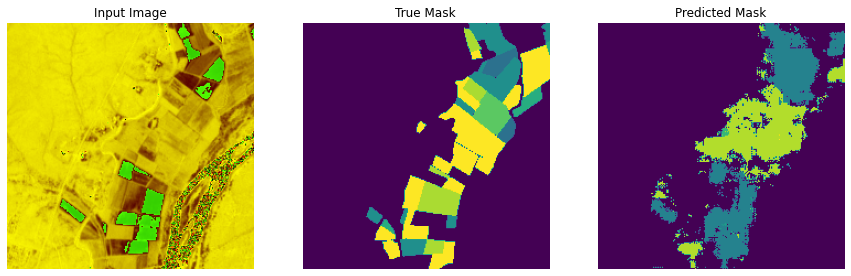


Sample Prediction after epoch 20

604/604 [==============================] - 376s 623ms/step - loss: 0.0508 - accuracy: 0.9732 - val_loss: 0.0726 - val_accuracy: 0.9653


In [62]:
EPOCHS = 20

model_history = model.fit(train_ds, 
                   steps_per_epoch=int(np.ceil(num_train_examples / float(batch_size))),
                   epochs=EPOCHS,
                   validation_data=val_ds,
                   validation_steps=int(np.ceil(num_val_examples / float(batch_size))),
                   callbacks=[DisplayCallback()]) 

Plot the model's learning curve over time.

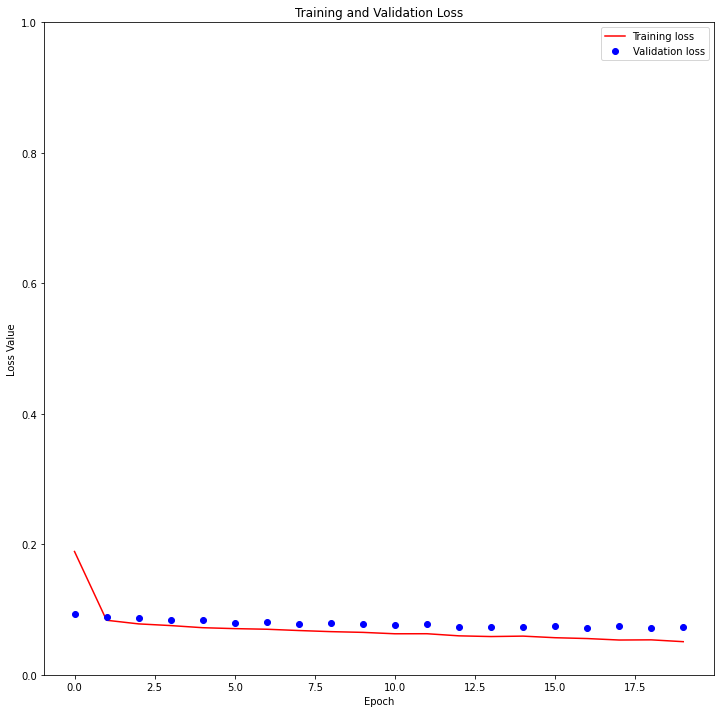

In [64]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

---------------------------------

### Make predictions

Let's make some predictions. In the interest of saving time, the number of epochs was kept small, but you may set this higher to achieve more accurate results.

In [65]:
def get_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      return pred_mask
  else:
    pred_mask = create_mask(model.predict(sample_image[tf.newaxis, ...]))
    pred_mask = tf.keras.backend.eval(pred_mask)
    return pred_mask

Single image example

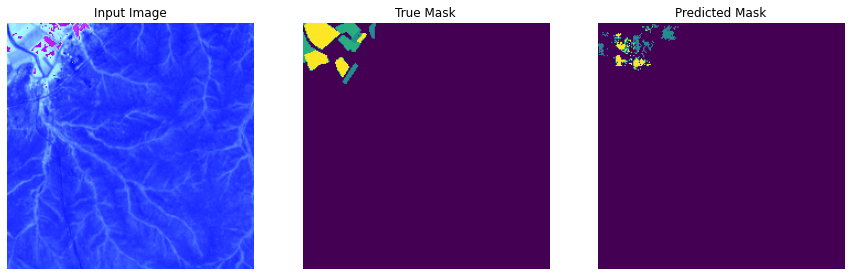

In [75]:
display_num = 1
r_choices = np.random.choice(num_foreground_examples, 1)
for i in range(0, display_num * 2, 2):
  img_num = r_choices[i // 2]

temp_ds = get_baseline_dataset(foreground_list_x[img_num:img_num+1], 
                               foreground_list_y[img_num:img_num+1],
                               preproc_fn=tr_preprocessing_fn,
                               batch_size=1,
                               shuffle=False)

# Let's examine some of these augmented images

iterator = iter(temp_ds)
next_element = iterator.get_next()

batch_of_imgs, label = next_element

# Running next element in our graph will produce a batch of images

sample_image, sample_mask = batch_of_imgs[0], label[0,:,:,:]

# run and plot predicitions
pred_mask = get_predictions()

show_predictions()

Multi image example

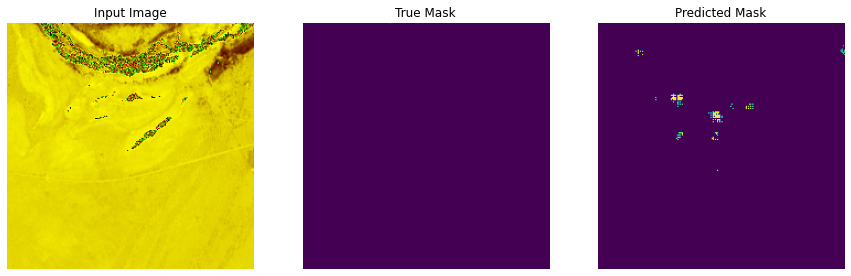

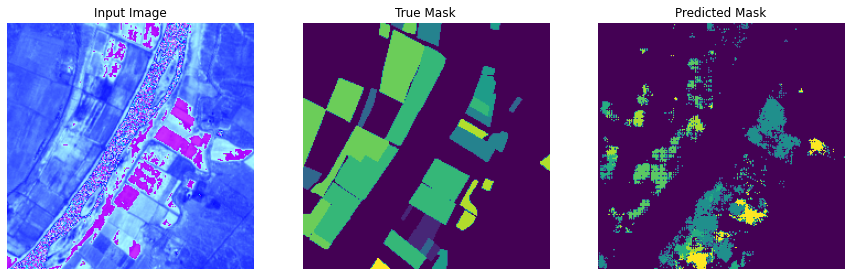

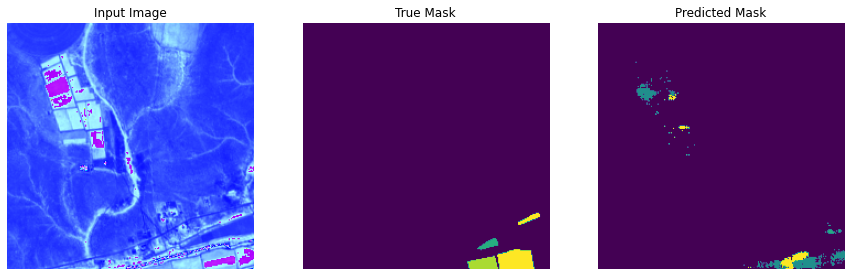

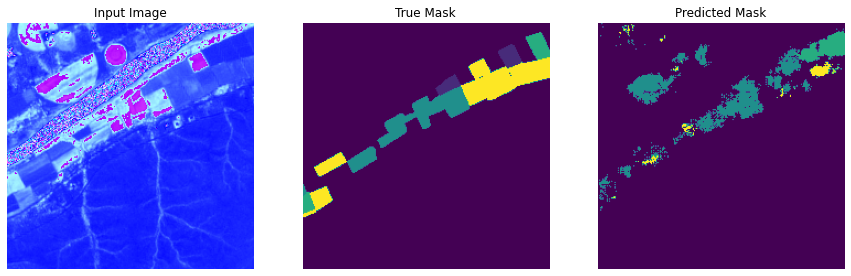

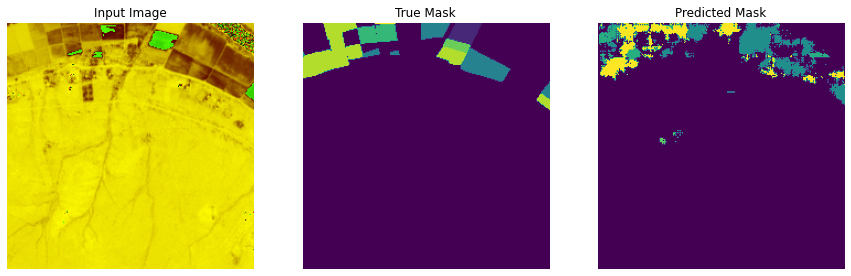

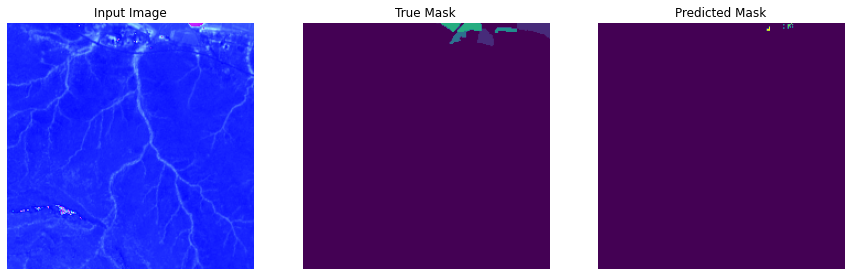

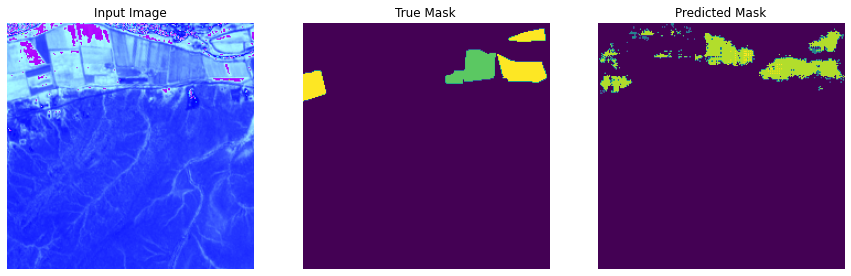

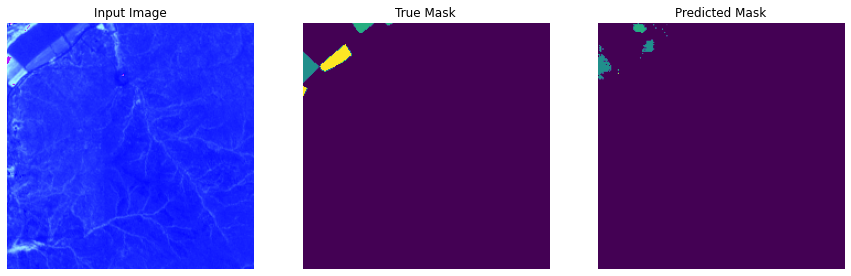

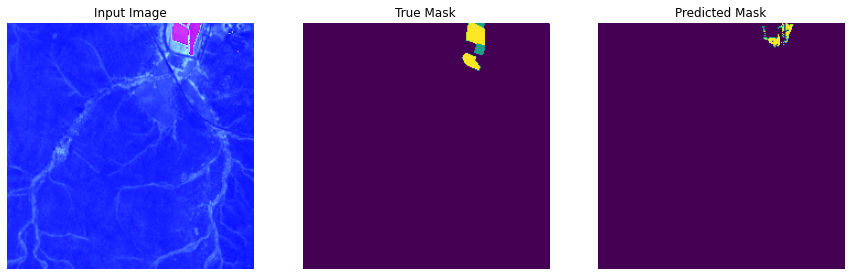

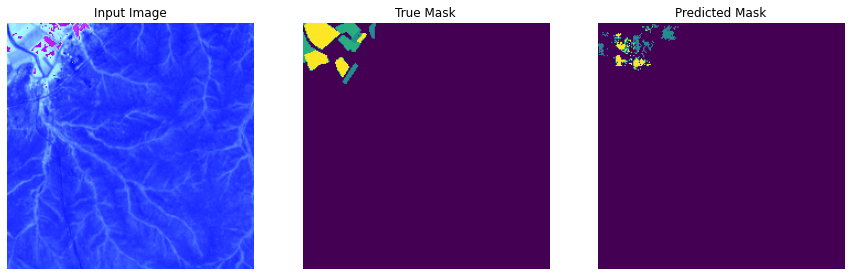

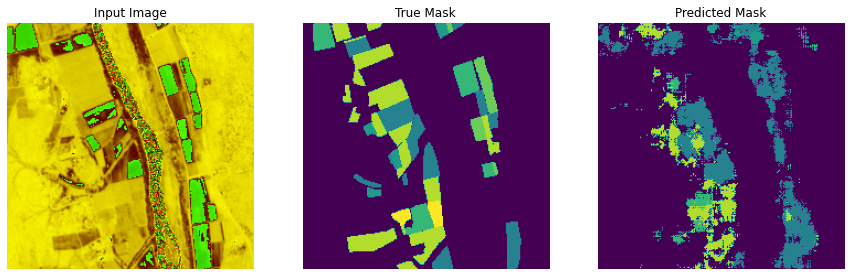

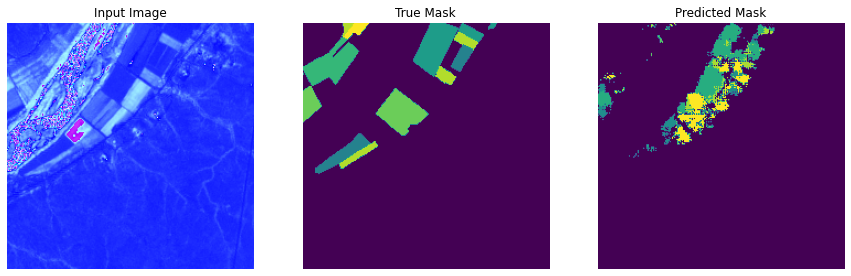

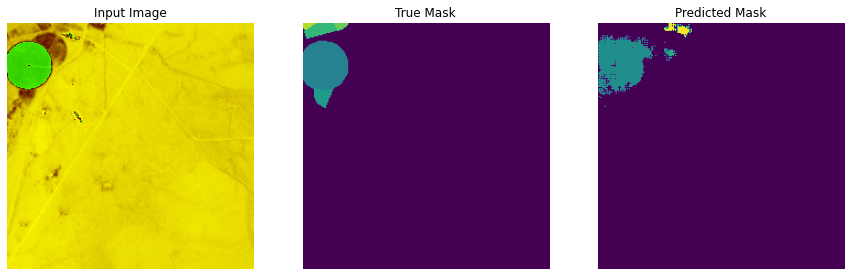

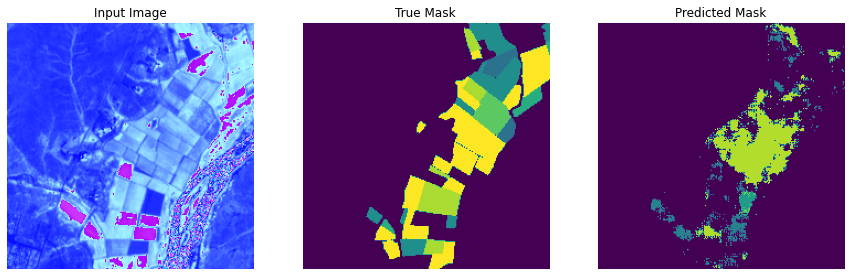

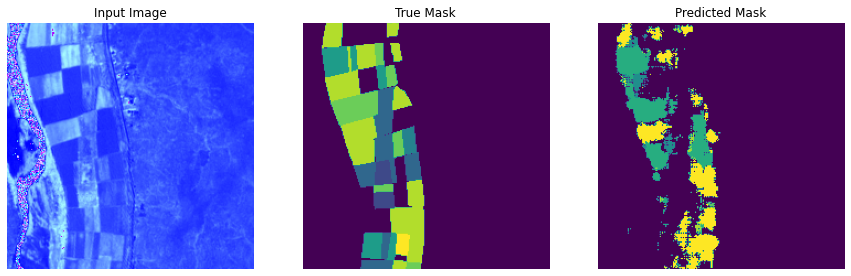

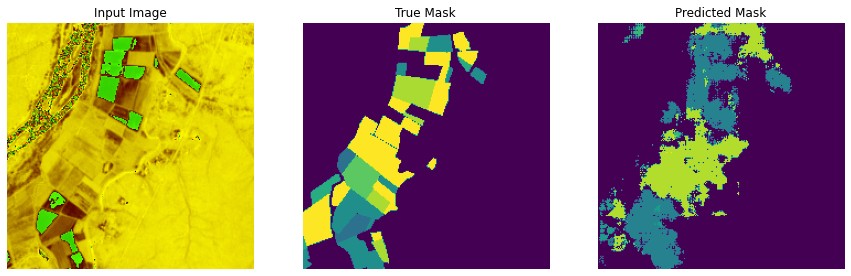

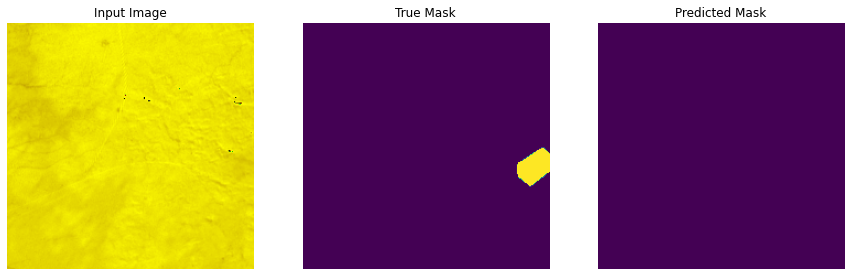

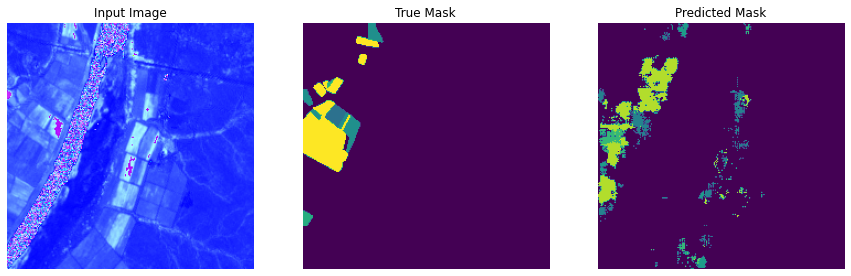

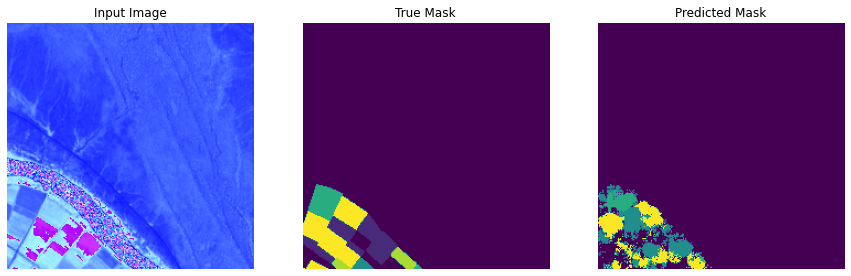

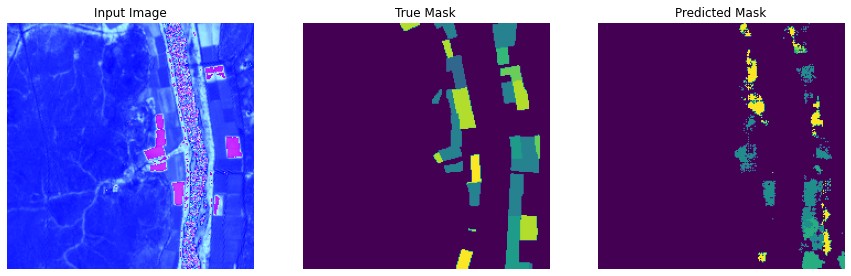

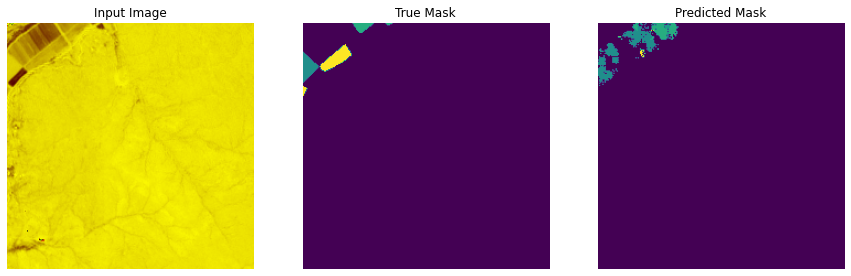

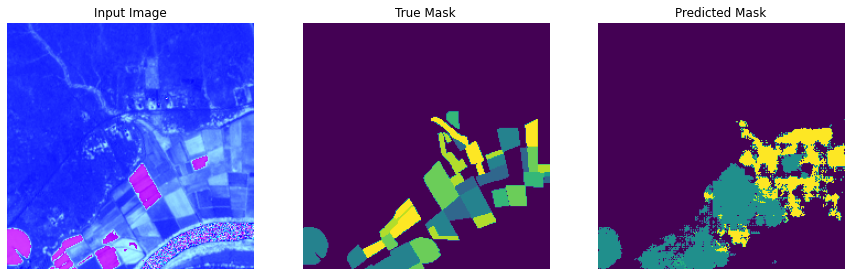

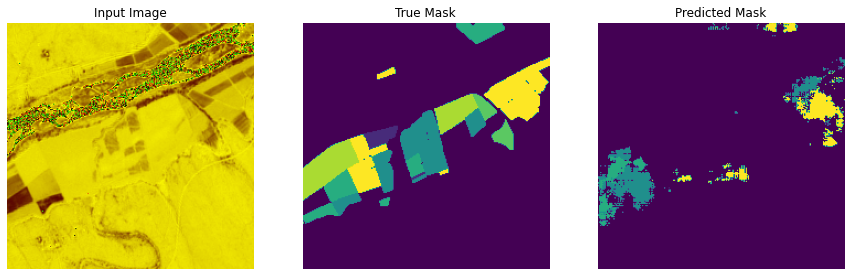

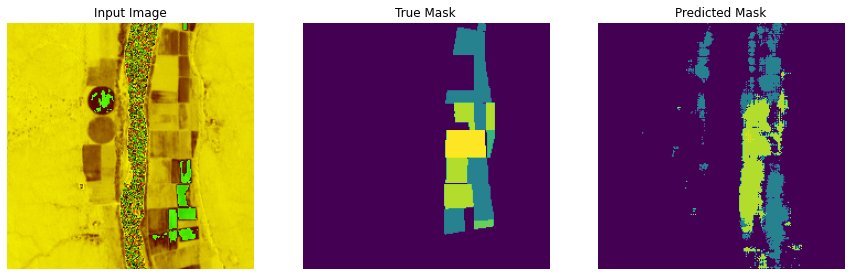

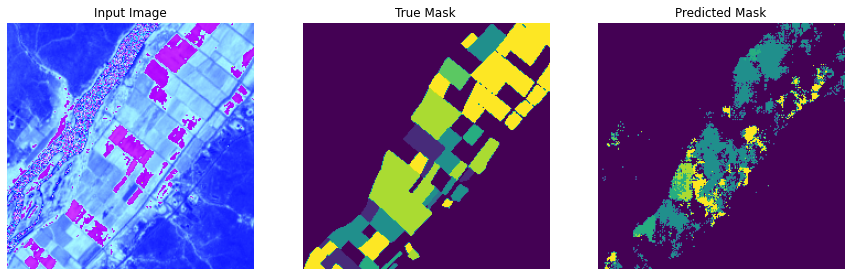

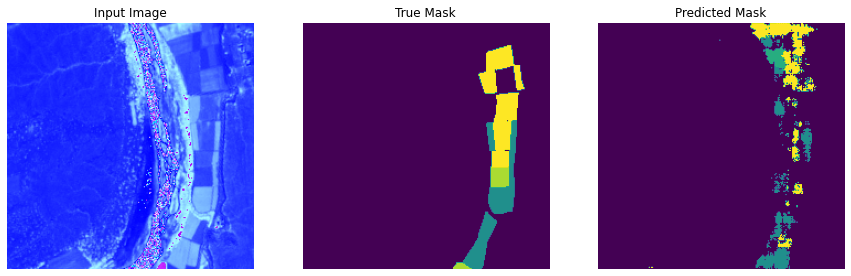

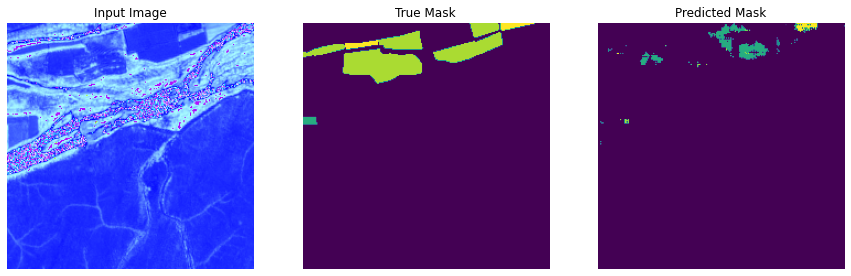

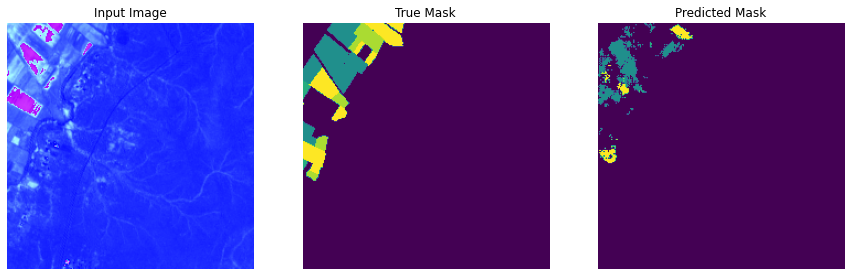

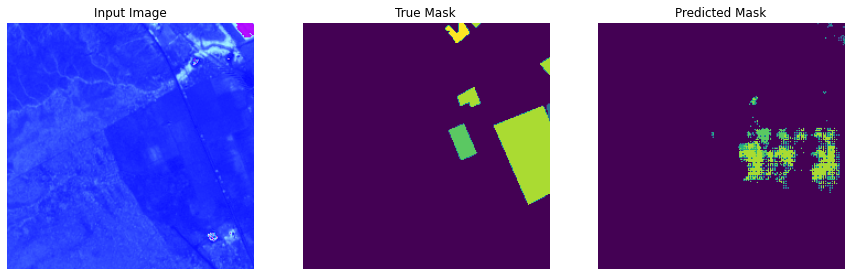

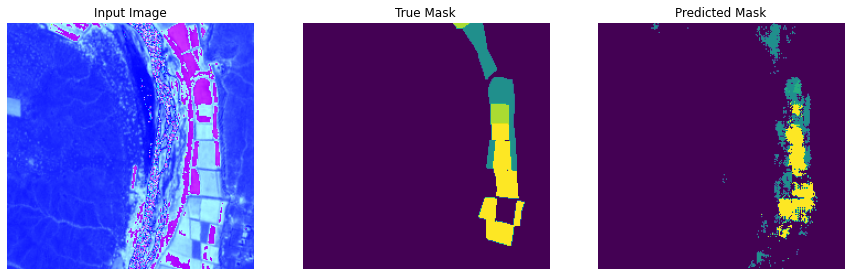

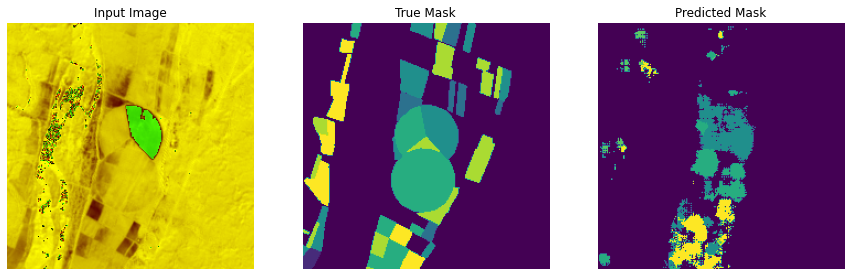

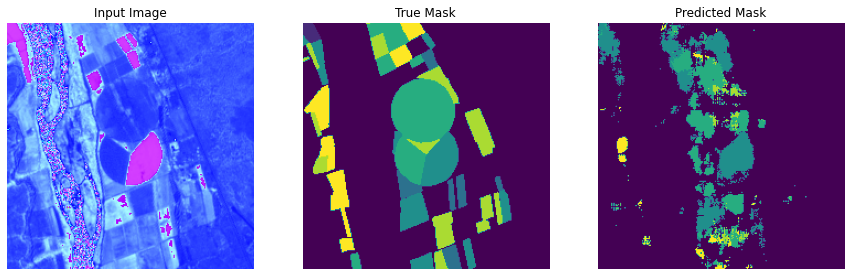

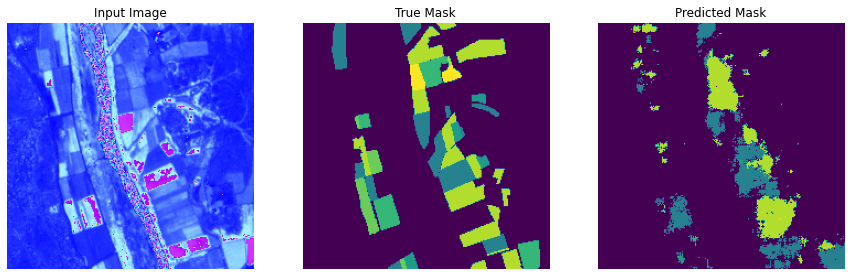

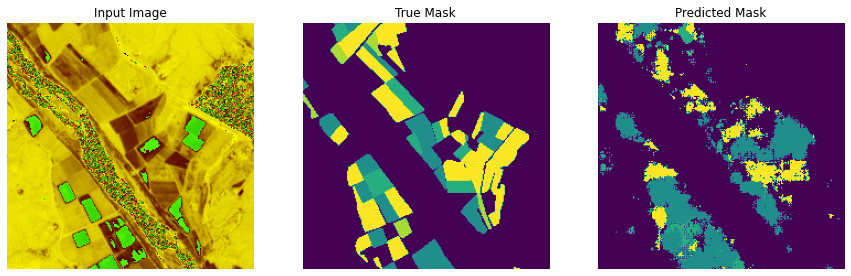

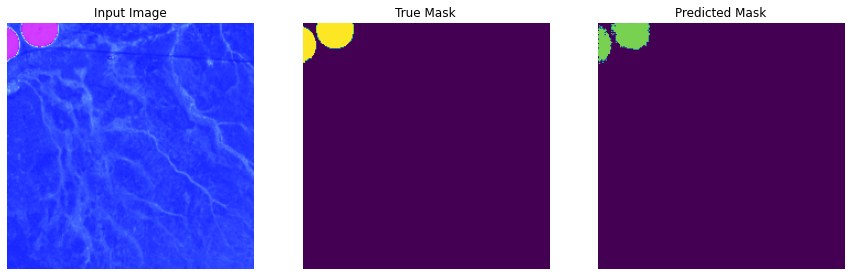

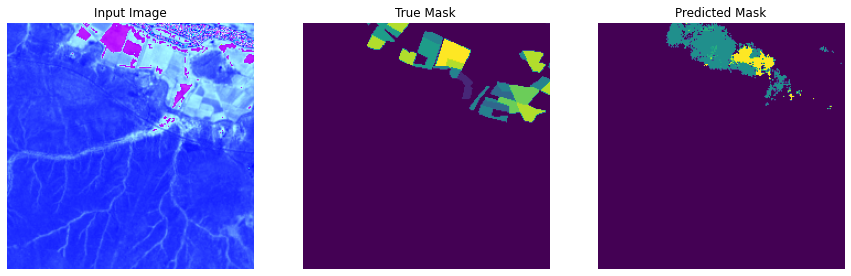

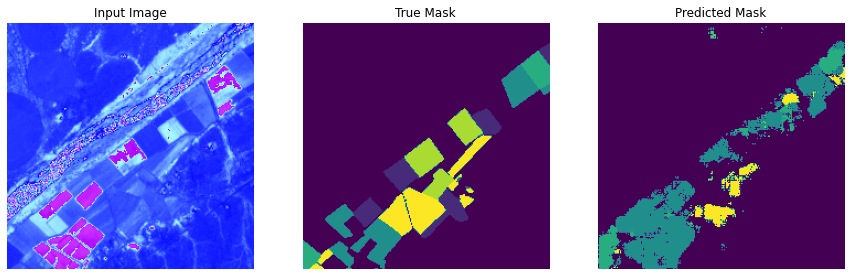

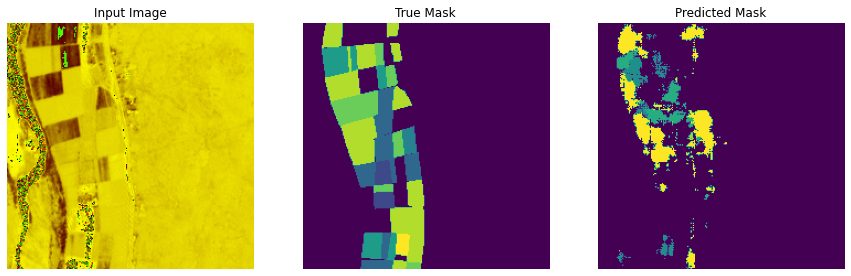

In [71]:
tiled_prediction_dir = os.path.join(root_dir,'tiled/predictions/')
if not os.path.exists(tiled_prediction_dir):
    os.makedirs(tiled_prediction_dir)
    
pred_masks = []
true_masks = []

for i in range(0, num_foreground_examples):
    img_num = i

    temp_ds = get_baseline_dataset(foreground_list_x[img_num:img_num+1], 
                                   foreground_list_y[img_num:img_num+1],
                                   preproc_fn=tr_preprocessing_fn,
                                   batch_size=1,
                                   shuffle=False)

    # Let's examine some of these augmented images

    iterator = iter(temp_ds)
    next_element = iterator.get_next()

    batch_of_imgs, label = next_element

    # Running next element in our graph will produce a batch of images

    sample_image, sample_mask = batch_of_imgs[0], label[0,:,:,:]
    true_masks.append(sample_mask)

    # run and plot predicitions
    show_predictions()
    pred_mask = get_predictions()
    pred_masks.append(pred_mask)
    
    # save prediction images to file

    filename_split = os.path.splitext(foreground_list_x[img_num]) 
    filename_zero, fileext = filename_split 
    basename = os.path.basename(filename_zero) 
    tf.keras.preprocessing.image.save_img(tiled_prediction_dir+'/'+basename+".png",pred_mask)    

Compute confusion matrix from all predicted images and their ground truth label masks. 

In [72]:
# flatten our tensors and use scikit-learn to create a confusion matrix
flat_preds = tf.reshape(pred_masks, [-1]) 
flat_truth = tf.reshape(true_masks, [-1]) 
cm = confusion_matrix(flat_truth, flat_preds, labels=list(range(OUTPUT_CHANNELS)))

In [73]:
# check values in predicted masks vs truth masks
check_preds = tf.keras.backend.eval(flat_preds)
check_truths = tf.keras.backend.eval(flat_truth)
print(np.unique(check_preds), np.unique(check_truths))

[0 1 3 4 5 6 7 8 9] [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]


(9.5, -0.5)

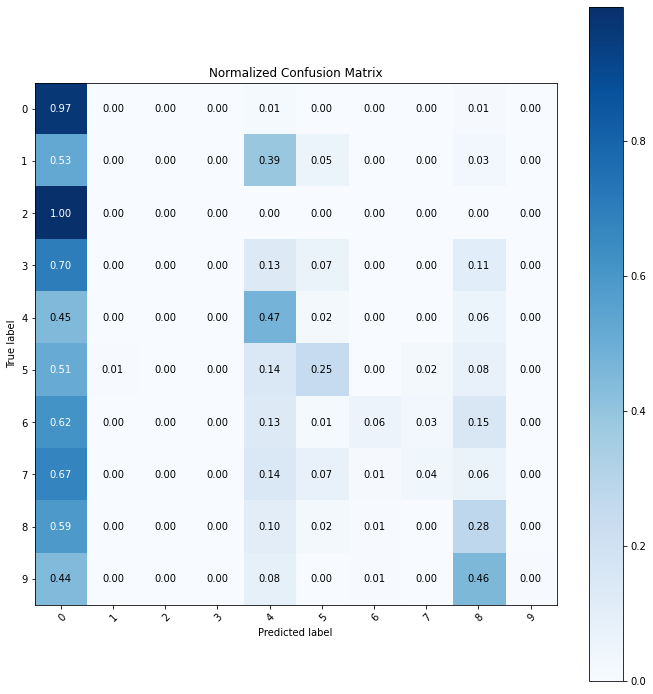

In [74]:
classes = [0,1,2,3,4,5,6,7,8,9]

%matplotlib inline
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       # ... and label them with the respective list entries
       xticklabels=list(range(OUTPUT_CHANNELS)), yticklabels=list(range(OUTPUT_CHANNELS)),
       title='Normalized Confusion Matrix',
       ylabel='True label',
       xlabel='Predicted label')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
fmt = '.2f' #'d' # if normalize else 'd'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
fig.tight_layout(pad=2.0, h_pad=2.0, w_pad=2.0)
ax.set_ylim(len(classes)-0.5, -0.5)

### Save model to file

We will export the final model weights.

In [77]:
save_model_path = os.path.join(root_dir,'model_out/')
!mkdir $save_model_path
model.save(save_model_path)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./model_out/assets
